In [35]:
"""
Change the folders' name to make it easier to process. 
Basically this section is to switch the order of pos and neg.
I want the pos cases go first, because there are fewer of
them, and I'm going to sample the neg cases based on how 
many pos cases I have.
"""

import os
path = '/Users/crl_imac/Documents/lymph_node_CT_data/ROI'

for root, dirs, filenames in os.walk(path):
    
    if not '.DS_Store' in filenames:
        continue
    
    if "roi" not in dirs[0]:
        continue
    
    for one_dir in dirs:
        
        if "neg" in one_dir:
            os.rename(os.path.join(root, one_dir),
                     os.path.join(root, '2'+one_dir))
        if "pos" in one_dir:
            os.rename(os.path.join(root, one_dir),
                     os.path.join(root, '1'+one_dir))
            

In [59]:
"""
This function is to point out the patients who only have 
negative roi.
"""

def find_only_neg(path):
    
    for root, dirs, filenames in os.walk(path, topdown=True):
        
        # "len(dirs) -> return True if not empty "
        if ('.DS_Store' in filenames) and (len(dirs)):
            continue
        
        if len(filenames):
            continue
            
        if len(dirs) == 1:
            print root

find_only_neg('/Users/crl_imac/Documents/lymph_node_CT_data/ROI')

/Users/crl_imac/Documents/lymph_node_CT_data/ROI/MED_LYMPH_010
/Users/crl_imac/Documents/lymph_node_CT_data/ROI/MED_LYMPH_030
/Users/crl_imac/Documents/lymph_node_CT_data/ROI/MED_LYMPH_045
/Users/crl_imac/Documents/lymph_node_CT_data/ROI/MED_LYMPH_062


#### From the output of checking function, we know that *MED10, MED30, MED45, MED62* just have negative cases. 

In [192]:
"""
This function is used to delete input roi that has zero in their 
dimension. Since we're going to do 2.5D here, when we delete one
patch, its corresponding sagittal/coronal/.. are going to be 
deleted as well. 
"""

def remove_zero_dimension(path):
    
    directory = "/Users/crl_imac/Documents/lymph_node_CT_data/Invalid_samples/Inconsistent_Dimension/invalid_info.txt"
    try:
        os.remove(directory)
    except OSError:
        pass
    
    dustbin = "/Users/crl_imac/Documents/lymph_node_CT_data/Invalid_samples/Inconsistent_Dimension/"
    for root, dirs, filenames in os.walk(path, topdown=True):
        
        if '.DS_Store' in filenames:
            continue
        
        for filename in filenames:

            image = np.load(os.path.join(root, filename))
            
            # if image.shape[0] == 0 or image.shape[1] == 0 or :
            if image.shape[0] != image.shape[1]:
                
                if "coronal" in filename:
                    other_name_one = filename.replace("coronal", "sagittal")
                    other_name_two = filename.replace("coronal", "axial")
                elif "sagittal" in filename:
                    other_name_one = filename.replace("sagittal", "coronal")
                    other_name_two = filename.replace("sagittal", "axial")
                elif "axial" in filename:
                    other_name_one = filename.replace("axial", "coronal")
                    other_name_two = filename.replace("axial", "sagittal")
                
                filenames.remove(filename)
                filenames.remove(other_name_one)
                filenames.remove(other_name_two)
                
                if not os.path.exists(dustbin + root[-22:-9]):
                    os.makedirs(dustbin + root[-22:-9])
                
                os.rename(os.path.join(root, filename), 
                          dustbin + root[-22:-9] +'/'+ root[-7:-4] + filename)
                os.rename(os.path.join(root, other_name_one), 
                          dustbin + root[-22:-9] +'/'+ root[-7:-4] + other_name_one)
                os.rename(os.path.join(root, other_name_two), 
                          dustbin + root[-22:-9] +'/'+ root[-7:-4] + other_name_two)
                
                base_info = os.path.join(root, filename)[-70:] + ' has a invalid shape of %s\n' % (str(np.shape(image)))
                other_info = "%s and %s will be deleted together\n\n" % (other_name_one, other_name_two)
                
                with open(directory, 'aw') as f:
                    f.write(base_info)
                    f.write(other_info)
                
                
remove_zero_dimension('/Users/crl_imac/Documents/lymph_node_CT_data/ROI')
    

#### After we run the "remove_zero_dimension" function, the roi left in the "ROI" folder should be valid. Next, we're going to construct image from this folder, and feed it into CNN

In [4]:
import sys

caffe_root = '/Users/crl_imac/Documents/caffe/'
sys.path.insert(0, caffe_root+'python')

import caffe

In [6]:
'''
Set up CNN and do image preprocessing.
'''
import numpy as np
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weight = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def, model_weight, caffe.TEST)

net.blobs['data'].reshape(50,        # batch size 
                        3,          # 3-channel(BGR) images
                        227, 227)   # image size

mu = np.load(caffe_root+'python/caffe/imagenet/ilsvrc_2012_mean.npy') # mu:(3, 256, 256)
mu = mu.mean(1).mean(1) # Obtain the mean (BGR) pixel values
transformer = caffe.io.Transformer({'data':net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR


In [7]:
def preprocess(image):
    
    image = (image - np.mean(image))/np.mean(image)
    transform_image = transformer.preprocess('data', image)
    
    return transform_image

In [213]:
"""
This function is to select three slices(axial, coronal, sagittal)
and input it into caffe network. 

To avoid any intermediate saving, which might be huge, after we 
get one input image, we directly feed it into the network to 
extract its features. 
"""

import os
import csv
from skimage.transform import resize

def generate_CNNinput(path, blobnames):
    
    directory = "/Users/crl_imac/Documents/DeepLearning/RESULT/CaffeNet/Off-the-shell/ABD_LYMPH/Input_info.txt"
    result_directory = "/Users/crl_imac/Documents/DeepLearning/RESULT/CaffeNet/Off-the-shell/ABD_LYMPH"
    
    blob_dict = {}
    for blob in blob_names:
        blob_dict[blob] = []
        try:
            os.remove(result_directory+'/'+blob+'.csv')
        except OSError:
            pass
    
    try:
        os.remove(directory)                                              
    except OSError:
        pass
    
    for root, dirs, filenames in os.walk(path, topdown=True):
        
        if '.DS_Store' in filenames:
            continue
        
        # Just do with ABD or MED once a time. 
        if "MED" in root:
            continue      
        
        if "pos" in root:
            
            new_filenames = [x for x in filenames if "ROT" not in x]
            newest_filenames = [y for y in new_filenames if "SCALE_0" in y]
            
            num_sample = len(newest_filenames)/3
            
            for filename in newest_filenames:
                
                image = np.load(os.path.join(root, filename))
                
                if "axial" in filename:
                    image_3D = image
                elif "coronal" in filename:
                    image_3D = np.dstack((image_3D, image))
                elif "sagittal" in filename:
                    image_3D = np.dstack((image_3D, image))
                
                    CNN_input = preprocess(image_3D)
                    net.blobs['data'].data[...] = CNN_input
                    output = net.forward()

                    for blob in blob_names:

                        feature = net.blobs[blob].data[0,:]

                        if "fc" in blob:
                            blob_dict[blob] = list(feature)

                        elif "conv" in blob:
                            blob_dict[blob] = np.mean(np.mean(feature, axis=1),axis=1)
                        
                        
                        with open(result_directory+'/'+blob+'.csv', 'aw') as fi:
                            writer = csv.writer(fi)
                            
                            writer.writerow(blob_dict[blob])
                
        elif 'neg' in root:
            
            new_filenames = [x for x in filenames if "ROT" not in x]
            newest_filenames = [y for y in new_filenames if "SCALE_0" in y]
            
            chosen_filenames = np.random.choice(newest_filenames, size=num_sample)
            
            for filename in chosen_filenames:
                
                image = np.load(os.path.join(root, filename))
                
                if "axial" in filename:
                    
                    coronal_filename = filename.replace('axial','coronal')
                    sagittal_filename = filename.replace('axial', 'sagittal')
                    coronal_image = np.load(os.path.join(root, coronal_filename))
                    sagittal_image = np.load(os.path.join(root, sagittal_filename))
                    image_3D = np.dstack((np.dstack((image, coronal_image)), sagittal_image))
                
                elif "coronal" in filename:
                    
                    axial_filename = filename.replace('coronal','axial')
                    sagittal_filename = filename.replace('coronal', 'sagittal')
                    axial_image = np.load(os.path.join(root, axial_filename))
                    sagittal_image = np.load(os.path.join(root, sagittal_filename))
                    image_3D = np.dstack((np.dstack((axial_image, image)), sagittal_image))
                    
                elif "sagittal" in filename:
                    
                    axial_filename = filename.replace('sagittal','axial')
                    coronal_filename = filename.replace('sagittal','coronal')
                    axial_image = np.load(os.path.join(root, axial_filename))
                    coronal_image = np.load(os.path.join(root, coronal_filename))
                    image_3D = np.dstack((np.dstack((axial_image, coronal_image)), image))
                
                CNN_input = preprocess(image_3D)
                net.blobs['data'].data[...] = CNN_input
                output = net.forward()
                
                for blob in blob_names:

                        feature = net.blobs[blob].data[0,:]

                        if "fc" in blob:
                            blob_dict[blob] = list(feature)

                        elif "conv" in blob:
                            blob_dict[blob] = np.mean(np.mean(feature, axis=1),axis=1)
                        
                        
                        with open(result_directory+'/'+blob+'.csv', 'aw') as fi:
                            writer = csv.writer(fi)
                            
                            writer.writerow(blob_dict[blob])
                
                # pdb.set_trace()
            
            
            print "Processed %s" % root[-23:-9]
            info1 = "%d pos samples from %s\n" % (num_sample, root[-23:-9])
            info2 = "%d neg samples from %s\n\n" % (num_sample, root[-23:-9])

            with open(directory, 'aw') as f:
                f.write(info1)
                f.write(info2)
        
   

In [214]:
blob_names = ['fc8', 'fc7', 'fc6', 'conv5', 'conv4', 'conv3', 'conv2', 'conv1']
data_path = '/Users/crl_imac/Documents/lymph_node_CT_data/ROI/'
generate_CNNinput(data_path, blob_names)

Processed /ABD_LYMPH_001
Processed /ABD_LYMPH_002
Processed /ABD_LYMPH_003
Processed /ABD_LYMPH_004
Processed /ABD_LYMPH_005
Processed /ABD_LYMPH_006
Processed /ABD_LYMPH_007
Processed /ABD_LYMPH_008
Processed /ABD_LYMPH_009
Processed /ABD_LYMPH_010
Processed /ABD_LYMPH_011
Processed /ABD_LYMPH_012
Processed /ABD_LYMPH_014
Processed /ABD_LYMPH_015
Processed /ABD_LYMPH_016
Processed /ABD_LYMPH_017
Processed /ABD_LYMPH_018
Processed /ABD_LYMPH_019
Processed /ABD_LYMPH_020
Processed /ABD_LYMPH_021
Processed /ABD_LYMPH_022
Processed /ABD_LYMPH_023
Processed /ABD_LYMPH_024
Processed /ABD_LYMPH_025
Processed /ABD_LYMPH_026
Processed /ABD_LYMPH_027
Processed /ABD_LYMPH_028
Processed /ABD_LYMPH_029
Processed /ABD_LYMPH_030
Processed /ABD_LYMPH_031
Processed /ABD_LYMPH_032
Processed /ABD_LYMPH_033
Processed /ABD_LYMPH_034
Processed /ABD_LYMPH_035
Processed /ABD_LYMPH_036
Processed /ABD_LYMPH_037
Processed /ABD_LYMPH_038
Processed /ABD_LYMPH_039
Processed /ABD_LYMPH_040
Processed /ABD_LYMPH_041


In [7]:
"""
Through running the above functions, we've obtained the feature vectors from CNN. 
Next we're going to use its output file "input_info.txt" to generate the label
message. 
"""

label_path = "/Users/crl_imac/Documents/DeepLearning/RESULT/CaffeNet/Off-the-shell/ABD_LYMPH/Input_info.txt"
import numpy as np
import pdb

def get_me_label(path):
    
    label = []
    labels = []
    with open(path, 'r') as file:
        
        for line in file:
                
            words = line.split()
            if words:
                labels.append(int(words[0]))
            
            if "pos" in words:
                
                label = np.append(label, np.zeros(int(words[0])))
                
            elif "neg" in words:
                
                label = np.append(label, np.ones(int(words[0])))
        
    
    print labels
    #np.savetxt('/Users/crl_imac/Documents/DeepLearning/RESULT/CaffeNet/Off-the-shell/ABD_LYMPH/label.txt',
    #          label)
        
    return labels

a = get_me_label(label_path)

[20, 20, 350, 350, 135, 135, 70, 70, 5, 5, 130, 130, 35, 35, 25, 25, 65, 65, 35, 35, 70, 70, 35, 35, 80, 80, 10, 10, 65, 65, 10, 10, 70, 70, 100, 100, 222, 222, 10, 10, 70, 70, 10, 10, 70, 70, 10, 10, 5, 5, 10, 10, 95, 95, 5, 5, 175, 175, 15, 15, 30, 30, 30, 30, 125, 125, 20, 20, 5, 5, 40, 40, 40, 40, 50, 50, 250, 250, 33, 33, 60, 60, 5, 5, 170, 170, 65, 65, 115, 115, 70, 70, 10, 10, 5, 5, 20, 20, 130, 130, 175, 175, 55, 55, 15, 15, 15, 15, 40, 40, 60, 60, 5, 5, 10, 10, 30, 30, 5, 5, 85, 85, 115, 115, 40, 40, 30, 30, 15, 15, 15, 15, 120, 120, 190, 190, 10, 10, 30, 30, 125, 125, 35, 35, 120, 120, 90, 90, 15, 15, 10, 10, 55, 55, 45, 45, 5, 5, 25, 25, 5, 5, 5, 5, 20, 20, 15, 15, 5, 5]


In [11]:
first_fold = sum(a[0:26]); second_fold=sum(a[26:52]); third_fold=sum(a[52:78]);
fourth_fold=sum(a[78:104]);fifth_fold=sum(a[104:130]);test_fold=sum(a[130:])

### The codes below are for debugging.

In [147]:
def check_stop_point(file1, file2, file3):
    
    image1 = np.load(file1); image2 = np.load(file2); image3 = np.load(file3);
    image_3D = np.dstack((np.dstack((image1, image2)), image3))
    CNN_input = preprocess(image_3D)
    net.blobs['data'].data[...] = CNN_input
    output = net.forward()
    
    feature = net.blobs["fc8"].data[0,:]
    np.savetxt("/Users/crl_imac/Documents/DeepLearning/RESULT/CaffeNet/Off-the-shell/ABD_LYMPH/test.csv",
              feature, delimiter=",")
    
    return None

rdir = "/Users/crl_imac/Documents/lymph_node_CT_data/ROI/ABD_LYMPH_003/1pos_roi/"
check_stop_point(rdir+"ROI_20_SCALE_1_trans_3_ROT_4_axial.npy",
                rdir+"ROI_20_SCALE_1_trans_3_ROT_4_coronal.npy",
                rdir+"ROI_20_SCALE_1_trans_3_ROT_4_sagittal.npy")
    

In [215]:
a = np.loadtxt("/Users/crl_imac/Documents/DeepLearning/RESULT/CaffeNet/Off-the-shell/ABD_LYMPH/conv3.csv", delimiter=",")

In [179]:
a = np.load("/Users/crl_imac/Documents/lymph_node_CT_data/ROI/ABD_LYMPH_003/1pos_roi/ROI_2_SCALE_0_trans_1_ROT_4_axial.npy")
b = np.load("/Users/crl_imac/Documents/lymph_node_CT_data/ROI/ABD_LYMPH_003/1pos_roi/ROI_2_SCALE_0_trans_1_ROT_4_coronal.npy")
c = np.load("/Users/crl_imac/Documents/lymph_node_CT_data/ROI/ABD_LYMPH_003/1pos_roi/ROI_2_SCALE_0_trans_1_ROT_4_sagittal.npy")

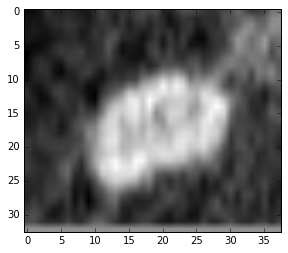

In [187]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(c, cmap='gray')

In [178]:
path1 = "/Users/crl_imac/Documents/lymph_node_CT_data/ROI/ABD_LYMPH_003/1pos_roi/"
i = 0
for root, dirs, filenames in os.walk(path1):
    
    for filename in filenames:
        
        i += 1
        
        if i == 7228 or i == 7229 or i==7230:
            print filename

ROI_2_SCALE_0_trans_1_ROT_4_axial.npy
ROI_2_SCALE_0_trans_1_ROT_4_coronal.npy
ROI_2_SCALE_0_trans_1_ROT_4_sagittal.npy


In [74]:
import pdb

pdb.run(generate_CNNinput(data_path, blob_names))

now we're going to 7 sample from the negative set
> /Users/crl_imac/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py(1803)showtraceback()
-> try:


KeyboardInterrupt: 